In [28]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.fft import dct as sp_dct
from scipy.fft import idct as sp_idct

from jlinops import _CustomLinearOperator
import jlinops

# First derivative

In [167]:
n = 10
R, W = jlinops.second_order_derivative_1d(n, boundary="none")
R = R.toarray()
A = R.T @ R

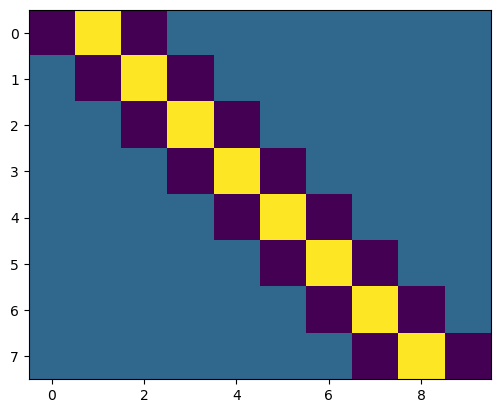

In [168]:
plt.imshow(R)
plt.show()

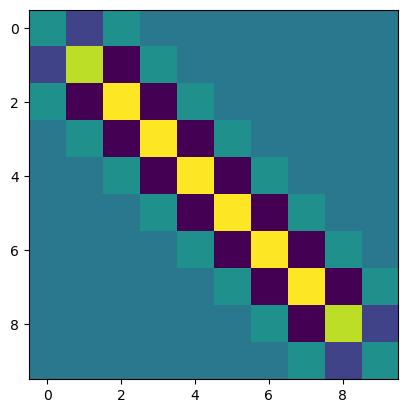

In [169]:
plt.imshow(A)
plt.show()

In [164]:
v = np.random.normal(size=n) + 10.0
#v = np.ones(n)
tmp = A @ sp_idct( v, norm="ortho" )  
tmp = sp_dct( tmp, norm="ortho" )
res = tmp/v.flatten()
# if make_pos:
#     res = np.abs(res)
# return res

In [165]:
res

array([2.57092048e-17, 9.78869674e-02, 3.81966011e-01, 8.24429495e-01,
       1.38196601e+00, 2.00000000e+00, 2.61803399e+00, 3.17557050e+00,
       3.61803399e+00, 3.90211303e+00])

In [166]:
np.linalg.eigvals(A)

array([ 3.90211303e+00,  3.61803399e+00,  3.17557050e+00,  2.61803399e+00,
        2.00000000e+00,  1.38196601e+00,  8.24429495e-01, -2.40543504e-16,
        9.78869674e-02,  3.81966011e-01])

In [29]:

class DCT(_CustomLinearOperator):
    """Represents a 1-dimensional DCT transform.
    """
    def __init__(self, n, device="cpu", type=2):
        
        # Handle shape
        self.n = n
        self.type = type
        shape = (n,n)
        
        if device == "cpu":
            
            def _matvec(x):
                return sp_dct( x, norm="ortho", type=self.type )
            
            def _rmatvec(x):
                return sp_idct( x, norm="ortho", type=self.type )
            
        else:
            
            raise NotImplementedError
        
            # def _matvec(x):
            #     return cp_dctn( x.reshape(self.grid_shape), norm="ortho", type=self.type ).flatten()
            
            # def _rmatvec(x):
            #     return cp_idctn( x.reshape(self.grid_shape), norm="ortho", type=self.type ).flatten()
              
        super().__init__(shape, _matvec, _rmatvec, device=device)
        
    
    def to_gpu(self):
        return DCT(self.n, device="gpu", type=self.type)
    
    def to_cpu(self):
        return DCT(self.n, device="cpu", type=self.type)


In [32]:
from jlinops import DiagonalOperator, first_order_derivative_1d

In [89]:
def get_1d_lap_reflexive_pinv(n, eps=1e-14):
    """Returns a linear operator implementing M^\dagger, 
    where M = R^T R is a laplacian with reflexive boundary 
    conditions made using first_order_derivative_1d
    with reflexive boundary.
    """

    R, _ = first_order_derivative_1d(n, boundary="reflexive")
    A = R.T @ R

    # Compute eigenvalues
    v = np.random.normal(size=n) + 10.0
    tmp = A @ sp_idct( v, norm="ortho" )  
    tmp = sp_dct( tmp, norm="ortho" )
    eigvals = tmp/v.flatten()
    
    # Take reciprocal of nonzeros and build pinv operator
    recip_eigvals = np.where( np.abs(eigvals) < eps, eigvals, 1.0 / np.clip(eigvals, a_min=eps, a_max=None) )
    recip_eigvals = np.where( np.abs(eigvals) < eps, np.zeros_like(eigvals), recip_eigvals )
    D = DiagonalOperator(recip_eigvals)
    P = DCT(n)

    return P.T @ (D @ P)

In [90]:
Mpinv2 = get_1d_lap_reflexive_pinv(10)

In [91]:
R, _ = jlinops.first_order_derivative_1d(n)
R = R.toarray()

In [92]:
A = R.T @ R

In [93]:
np.linalg.norm( np.linalg.pinv(A) - jlinops.black_box_to_dense(Mpinv2) )

4.5096057258543755e-14

# Try it on the weighted version

In [97]:
from scipy.sparse.linalg import cg
import scipy.sparse as sps

In [125]:
np.random.seed(0)

n = 1000
R, W = jlinops.first_order_derivative_1d(n)
Wpinv = np.linalg.pinv(W)
w = np.random.uniform(low=1e-1, high=1e1, size=R.shape[0])
L = R.T @ sps.diags(w) @ R
b = np.random.normal(size=n)
b -= W @ (Wpinv @ b)

In [128]:
tol = 1e-1

iteration_count = [0]
def callback(xk):
    iteration_count[0] += 1

sol, _ = cg(L, b, tol=tol, callback=callback)
tot_its = iteration_count[0]
print(f"without preconditioner: {tot_its}")


Mpinv = get_1d_lap_reflexive_pinv(n)

iteration_count = [0]
def callback(xk):
    iteration_count[0] += 1

sol, _ = cg(L, b, tol=tol, callback=callback, M=Mpinv)
tot_its = iteration_count[0]
print(f"with preconditioner: {tot_its}")

without preconditioner: 1214
with preconditioner: 26


# Make pinv CG operator

In [130]:
from jlinops import QRPinvOperator
from scipy.sparse.linalg import cg as sp_cg

In [144]:
class PCGSSPDPinvOperator(_CustomLinearOperator):
    """Returns a linear operator that approximately computes the pseudoinverse of a SSPD matrix A using 
    a preconditioned conjugate gradient method. Modifed so that it only ever solves systems with A^T A. 
    
    W: a LinearOperator representing a matrix with linearly independent columns that spans null(A).
    Wpinv: a LinearOperator represening the pseudoinverse of W.
    Mpinv: preconditioner with col(M) = col(A).
    """

    def __init__(self, A, Mpinv, W, Wpinv=None, check=False, *args, **kwargs):
        
        device = A.device
        n = A.shape[1]
        shape = (n,n)
        self.A = A
        self.Mpinv = Mpinv
        self.W = W
        self.check = check

        # Build Wpinv if not passed
        if Wpinv is None:
            self.Wpinv = QRPinvOperator(W.A)
        else:
            self.Wpinv = Wpinv

        if device == "cpu":

            def _matvec(x):
                # Project onto col(A)
                x -= self.W @ (self.Wpinv @ x)
                sol, converged = sp_cg(self.A, x, *args, **kwargs) 
                if self.check:
                    assert converged == 0, "CG algorithm did not converge!"
                
                return sol
        else:
            raise NotImplementedError





        super().__init__( shape, _matvec, _matvec, dtype=np.float64, device=device)
        
        
    def to_gpu(self):
        raise NotImplementedError
       
    
        
    def to_cpu(self):
        raise NotImplementedError
    

In [145]:
np.random.seed(0)

n = 1000
R, W = jlinops.first_order_derivative_1d(n)
Wpinv = np.linalg.pinv(W)
Mpinv = get_1d_lap_reflexive_pinv(n)
w = np.random.uniform(low=1e-1, high=1e1, size=R.shape[0])
L = jlinops.MatrixLinearOperator(R.T @ sps.diags(w) @ R)

In [150]:
Apinv = PCGSSPDPinvOperator(L, Mpinv, jlinops.MatrixLinearOperator(W), jlinops.MatrixLinearOperator(Wpinv) , tol=1e-8)

In [152]:
Apinv_true = np.linalg.pinv(L.A.toarray())
for j in range(20):
    u = np.random.normal(size=n)
    true_matvec = Apinv_true @ u
    test_matvec = Apinv @ u
    print(np.linalg.norm(true_matvec - test_matvec))

8.437075827375068e-07
9.276002891748891e-07
4.231744839698986e-06
1.6763477847182637e-06
9.104792383371485e-07
3.812797847443244e-07
1.7733535164671878e-06
3.0573908715995366e-07
1.5840570778420764e-06
4.603522715252106e-06
4.631035208994678e-06
2.4978050033916537e-06
2.039936714068831e-06
3.3085589965239385e-06
1.2953424304304457e-06
7.723378719655148e-07
3.7697530158048492e-06
2.370971529029612e-06
1.6098288875584443e-06
1.3936497207843411e-06


# Now operator that builds it

In [ ]:
class Weighted1DGradGramPinv:

    def __init__(self, n, weights, order=1):

        
        self.order = order
        if self.order == 1:
            R, W = first_order_derivative_1d(n, boundary="none")
        elif self.order == 2:
            R, W = first_order_derivative_1d(n, boundary="none")
        elif self.order == 3:
            return 

In [155]:
jlinops.second_order_derivative_1d(10, boundary="none")

(<8x10 sparse matrix of type '<class 'numpy.float64'>'
 	with 24 stored elements in List of Lists format>,
 array([[0.31622777, 0.        ],
        [0.31622777, 0.05923489],
        [0.31622777, 0.11846978],
        [0.31622777, 0.17770466],
        [0.31622777, 0.23693955],
        [0.31622777, 0.29617444],
        [0.31622777, 0.35540933],
        [0.31622777, 0.41464421],
        [0.31622777, 0.4738791 ],
        [0.31622777, 0.53311399]]))

In [156]:

def second_order_derivative_1d(N, boundary="none"):
    """Constructs a SciPy sparse matrix that extracts the (1D) discrete gradient of an input signal.
    Boundary parameter specifies how to handle the boundary conditions.
    """
    
    assert boundary in ["none"], "Invalid boundary parameter."
    
    d_mat = -sps.eye(N)
    d_mat.setdiag(2,k=1)
    d_mat.setdiag(-1,k=2)
    d_mat = d_mat.tolil()
    
    if boundary == "periodic":
        d_mat[-2,0] = -1
        d_mat[-1,0] = 2
        d_mat[-1,1] = -1
        raise NotImplementedError
    elif boundary == "zero":
        raise NotImplementedError
    elif boundary == "none":
        d_mat = d_mat[:-2, :]
        w1 = np.ones(N)/np.linalg.norm(np.ones(N))
        w2 = np.arange(N)/np.linalg.norm(np.arange(N))
        W = np.vstack([w1, w2]).T
    else:
        pass
    
    return d_mat, W

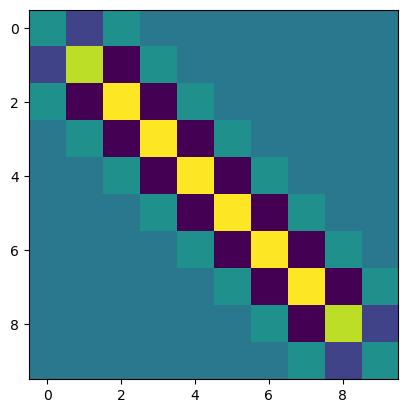

In [159]:
R, _ = second_order_derivative_1d(10, boundary="none")
R = R.toarray()

plt.imshow(R.T @ R)
plt.show()

In [160]:
R, _ = second_order_derivative_1d(10, boundary="none")
R = R.toarray()

plt.imshow(R.T @ R)
plt.show()

AssertionError: Invalid boundary parameter.